### Test for SNR requirement

#### 1. Set working enviroment

In [1]:
import sys
sys.path.append("/home/jochen/pythonenvs/tangoendtoend/lib64/python3.11/site-packages")
import os
import yaml
import numpy as np
from netCDF4 import Dataset
from copy import deepcopy
import matplotlib.pyplot as plt

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp5_snr/")

#### 2. import teds modules

In [2]:
from teds.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.l1l2.l1bl2 import level1b_to_level2_processor_RTorCH4, level1b_to_level2_processor
from teds.lib.libNumTools import get_isrf
from teds.siml1b import simplified_instrument_model_and_l1b_processor

### 3. Set overall path and flags to swich on/off cells

In [4]:
path  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'

proc_gm     = False
proc_sgmgeo = False
proc_sgmrad = False
proc_im     = False
proc_l1al1b = False
proc_siml1b = False
proc_l1bl2  = True
proc_data_aly_l1b = False
proc_data_aly_l2  = True

### 4. GM

In [5]:
if(proc_gm):
    #configureation file
    #In this case, the gm does not include solar and viewing geometry. It is easier to define them with the notebook
    gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
    #we use the nact dimension to simulate scenes with different scaling factors s and the geometry of Lref
    nact = 100 
    gm_config['scene_spec'] = {}
    gm_config['scene_spec']['sza'] = np.zeros(nact) + 70.
    gm_config['scene_spec']['saa'] = np.zeros(nact) 
    gm_config['scene_spec']['vza'] = np.zeros(nact) 
    gm_config['scene_spec']['vaa'] = np.zeros(nact) 

    geometry_module(gm_config)


#### 5. SGM-GEO

In [6]:
if(proc_sgmgeo):

    albedo = np.ones(nact)*0.15
    sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config.yaml'))
    sgmgeo_config['scene_spec']={}
    sgmgeo_config['scene_spec']['albedo'] = albedo
    sgmgeo_config['io_files']['output_geo']=path+'sgm/Tango_Carbon_sgm_atmosphere_exp5.0.nc'
    geoscene_generation(sgmgeo_config)

#### 6. SGM-RAD

In [7]:
if(proc_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config.yaml'))
    sgmrad_config['io_files']['input_sgm_geo']=path+'sgm/Tango_Carbon_sgm_atmosphere_exp5.0.nc'
    sgmrad_config['io_files']['output_rad']=path + 'sgm/Tango_Carbon_sgm_radiance_exp5.0.nc'
    Carbon_radiation_scene_generation(sgmrad_config)

### 7. Instrument model 

Run the instrument model for each scaled scenes using a seperate call 

In [8]:
if(proc_im):
    im_config= yaml.safe_load(open('./settings/im_config.yaml'))
    im_config['io']['sgm'] = path + 'sgm/Tango_Carbon_sgm_radiance_exp5.0.nc'
    im_config['io']['l1a'] = path + 'level1a/Tango_Carbon_l1a_exp5.0_bin5.nc'
    im_config['detector']['binning_table_id'] = 5  
    run_instrument_model(im_config)

    im_config['io']['sgm'] = path + 'sgm/Tango_Carbon_sgm_radiance_exp5.0.nc'
    im_config['io']['l1a'] = path + 'level1a/Tango_Carbon_l1a_exp5.0_bin1.nc'
    im_config['detector']['binning_table_id'] = 1  
    run_instrument_model(im_config)

#### 8. L1B processing

In [9]:
if(proc_l1al1b):
    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    l1al1b_config['io']['l1a'] = path + 'level1a/Tango_Carbon_l1a_exp5.0_bin5.nc'
    l1al1b_config['io']['l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_bin5.nc'
    run_l1al1b(l1al1b_config)

    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    l1al1b_config['io']['l1a'] = path + 'level1a/Tango_Carbon_l1a_exp5.0_bin1.nc'
    l1al1b_config['io']['l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_bin1.nc'
    run_l1al1b(l1al1b_config)


### 9. Simplified L1B processor

In [10]:
if(proc_siml1b):
    siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
    siml1b_config['io_files']['output_l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_sim.nc'
    simplified_instrument_model_and_l1b_processor(siml1b_config)

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

=>siml1b calculation finished successfully


### 10. Data analysis level 1B

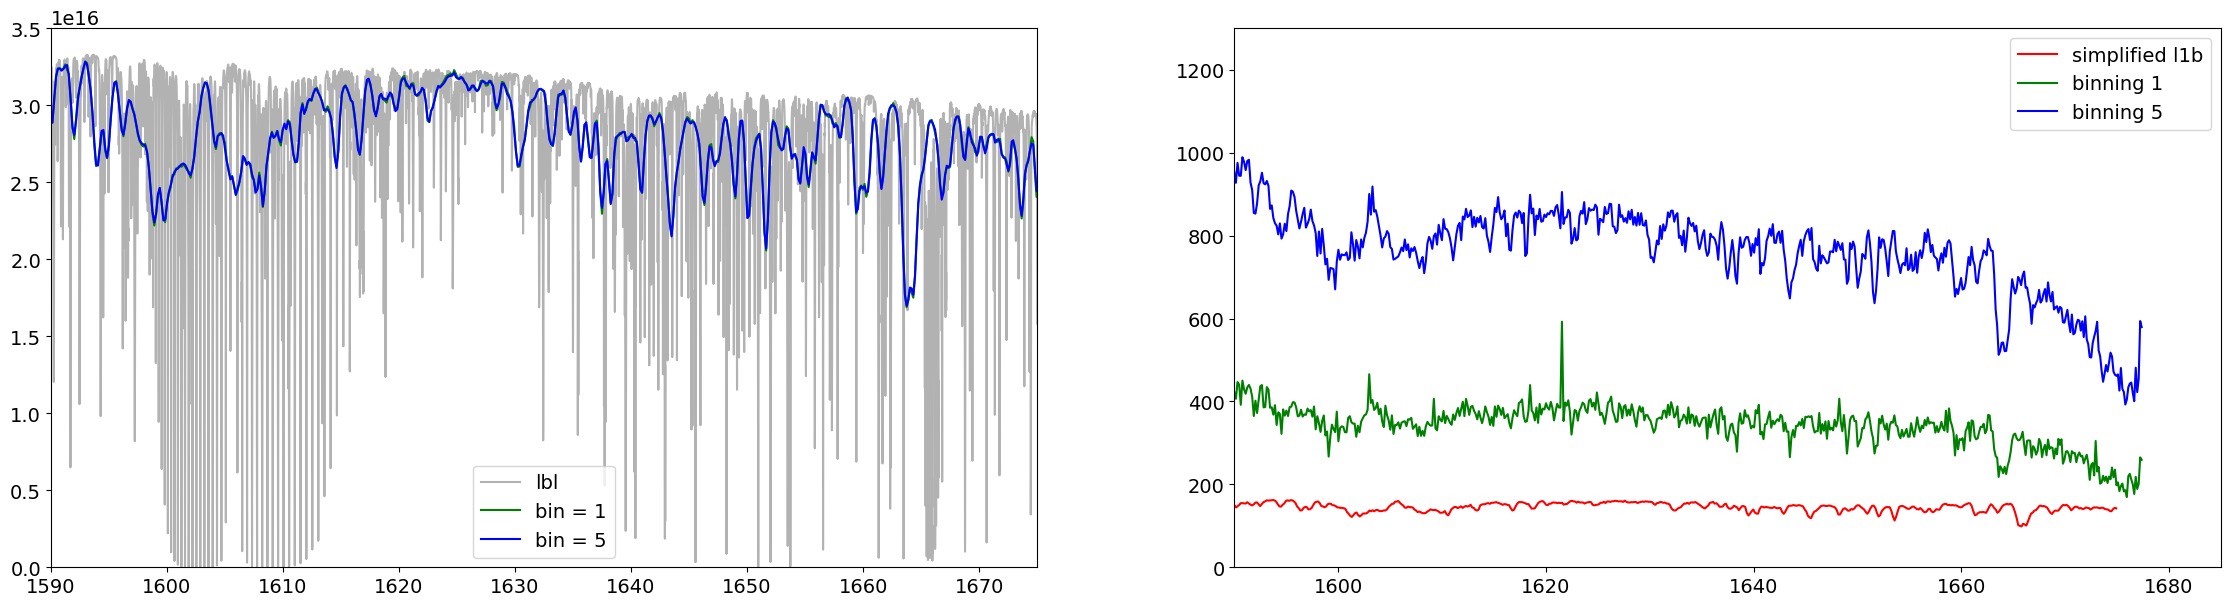

In [29]:
if(proc_data_aly_l1b):
    
    plt.rcParams.update({'font.size': 14,})
    path ='/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'

    nact  = 100
    nwave = 550

    filenamel1b = path + 'level1b/Tango_Carbon_l1b_exp5.0_bin1.nc'
    l1b_data = Dataset(filenamel1b)
    wave_b1  = np.array(deepcopy(l1b_data['observation_data']['wavelength'][:]))
    rad_b1   = np.array(deepcopy(l1b_data['observation_data']['radiance'][:]))
    noise_b1 = np.array(deepcopy(l1b_data['observation_data']['radiance_stdev'][:]))
    snr_b1   = rad_b1/noise_b1

    filenamel1b = path + 'level1b/Tango_Carbon_l1b_exp5.0_bin5.nc'
    l1b_data = Dataset(filenamel1b)
    wave_b5  = np.array(deepcopy(l1b_data['observation_data']['wavelength'][:]))
    rad_b5   = np.array(deepcopy(l1b_data['observation_data']['radiance'][:]))
    noise_b5 = np.array(deepcopy(l1b_data['observation_data']['radiance_stdev'][:]))
    snr_b5   = rad_b5/noise_b5

    filenamel1b = path + 'level1b/Tango_Carbon_l1b_exp5.0_sim.nc'
    l1b_data = Dataset(filenamel1b)
    wave_sim  = np.array(deepcopy(l1b_data['observation_data']['wavelength'][:]))
    rad_sim   = np.array(deepcopy(l1b_data['observation_data']['radiance'][:]))
    noise_sim = np.array(deepcopy(l1b_data['observation_data']['radiance_stdev'][:]))
    snr_sim   = rad_sim/noise_sim

    # SGMRAD data 
    filename_lbl = path + 'sgm/Tango_Carbon_sgm_radiance_exp5.0.nc'
    sgm_data = Dataset(filename_lbl)
    wave_lbl = sgm_data['wavelength']
    rad_lbl  = sgm_data['radiance']


    fig = plt.figure(figsize=(28, 7), dpi=100,)
    ax0 = fig.add_subplot(121)
    ax0.plot(wave_lbl[:], rad_lbl[0,50,:], color = 'grey', alpha = 0.6, label = 'lbl')
    ax0.plot(wave_b1[0,:], rad_b1[0,50,:], color = 'green', label = 'bin = 1')
    ax0.plot(wave_b5[0,:], rad_b5[0,50,:], color = 'blue', label = 'bin = 5')

    #ax0.plot(wave_sim[0,:], rad_sim[0,50,:], color = 'red', label = 'siml1b')
    ax0.set_ylim([0.0,3.5E16])
    ax0.set_xlim([1590,1675])
    plt.legend()

    ax1 = fig.add_subplot(122)
    ax1.plot(wave_sim[0,:], snr_sim[0,50,:], color = 'red', label = 'simplified l1b')
    ax1.plot(wave_b1[0,:], snr_b1[0,50,:], color = 'green', label = 'binning 1')
    ax1.plot(wave_b5[0,:], snr_b5[0,50,:], color = 'blue', label = 'binning 5')

    ax1.set_xlim([1590,1685])
    ax1.set_ylim([0.0,1300])

    plt.legend()

### 11. Level 2

In [31]:
if(proc_l1bl2):
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    l1bl2_config['io_files']['input_l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_bin5.nc'
    l1bl2_config['io_files']['output_l2'] = path + 'level2/Tango_Carbon_l2_exp5.0_bin5.nc'
    level1b_to_level2_processor(l1bl2_config)

    l1bl2_config['io_files']['input_l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_bin1.nc'
    l1bl2_config['io_files']['output_l2'] = path + 'level2/Tango_Carbon_l2_exp5.0_bin1.nc'
    level1b_to_level2_processor(l1bl2_config)

    l1bl2_config['io_files']['input_l1b'] = path + 'level1b/Tango_Carbon_l1b_exp5.0_sim.nc'
    l1bl2_config['io_files']['output_l2'] = path + 'level2/Tango_Carbon_l2_exp5.0_sim.nc'
    level1b_to_level2_processor(l1bl2_config)

level 1B to 2 proessor ...


100%|██████████| 1/1 [02:07<00:00, 127.14s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_bin5.nc
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:56<00:00, 116.30s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_bin1.nc
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:27<00:00, 87.45s/it]

/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp5.0_sim.nc
=> l1bl2 finished successfully


### 12. Data Analysis Level 2 

2.0170177767427115
4.485901850898189
5.663440498091057


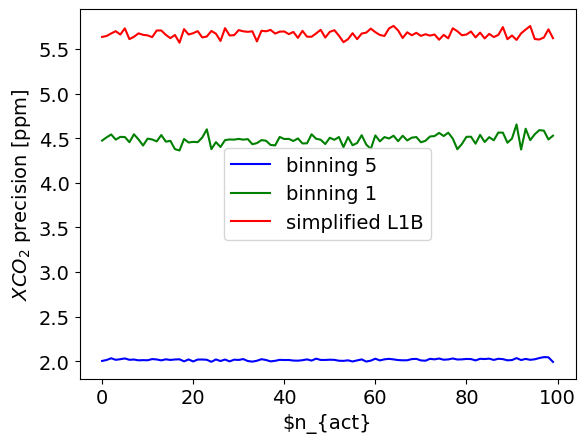

In [33]:
if(proc_data_aly_l2):
    filen  = path + 'level2/Tango_Carbon_l2_exp5.0_bin5.nc'
    l2_data  = Dataset(filen)
    prec_xco2_proxy_bin5 = np.array(deepcopy(l2_data['precision XCO2 proxy'][:]).flatten())
    l2prec_median_bin5 = np.median(prec_xco2_proxy_bin5)
    print(l2prec_median_bin5)

    filen  = path + 'level2/Tango_Carbon_l2_exp5.0_bin1.nc'
    l2_data  = Dataset(filen)
    prec_xco2_proxy_bin1 = np.array(deepcopy(l2_data['precision XCO2 proxy'][:]).flatten())
    l2prec_median_bin1 = np.median(prec_xco2_proxy_bin1)
    print(l2prec_median_bin1)

    filen  = path + 'level2/Tango_Carbon_l2_exp5.0_sim.nc'
    l2_data  = Dataset(filen)
    prec_xco2_proxy_sim = np.array(deepcopy(l2_data['precision XCO2 proxy'][:]).flatten())
    l2prec_median_sim = np.median(prec_xco2_proxy_sim)
    print(l2prec_median_sim)

    plt.plot(prec_xco2_proxy_bin5, color = 'blue', label = 'binning 5')
    plt.plot(prec_xco2_proxy_bin1, color = 'green', label = 'binning 1')
    plt.plot(prec_xco2_proxy_sim, color = 'red', label = 'simplified L1B')
    plt.legend()
 
    plt.xlabel('$n_{act}')
    plt.ylabel('$XCO_2$ precision [ppm]')